# Forecaster explainability: SHAP values and Partial dependence plots

SHAP (SHapley Additive exPlanations) values are a popular method for explaining machine learning models, as they help to understand how variables and values influence predictions visually and quantitatively.

It is possible to generate SHAP-values explanations from Skforecast models with just two essential elements:

+ The internal regressor of the forecaster.

+ The training matrices created from the time series and used to fit the forecaster.

By leveraging these two components, users can create insightful and interpretable explanations for their skforecast models. These explanations can be used to verify the reliability of the model, identify the most significant factors that contribute to model predictions, and gain a deeper understanding of the underlying relationship between the input variables and the target variable.

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>
<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px;
border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px;">
<p class="title">
    <i class="fa-light fa-pencil fa" style="font-size: 18px; color:#00b8d4;"></i>
    <b> &nbsp Note</b>
</p>

See also: <a href="https://skforecast.org/latest/user_guides/feature-importances.html">Feature importances</a>

</div>

## Libraries

In [71]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.datasets import fetch_dataset
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
import shap
shap.initjs()

## Data

The data used in this example has been obtained from the R tsibbledata package. The dataset contains 5 columns and 52,608 complete records. The information in each column is:

+ Time: date and time of the record.
+ Date: date of the record.
+ Demand: electricity demand (MW).
+ Temperature: temperature in Melbourne, the capital of Victoria.
+ Holiday: indicates if the day is a public holiday.

In [72]:
# Download data
# ==============================================================================
data = fetch_dataset(name="vic_electricity")
data.head(3)

vic_electricity
---------------
Half-hourly electricity demand for Victoria, Australia
O'Hara-Wild M, Hyndman R, Wang E, Godahewa R (2022).tsibbledata: Diverse
Datasets for 'tsibble'. https://tsibbledata.tidyverts.org/,
https://github.com/tidyverts/tsibbledata/.
https://tsibbledata.tidyverts.org/reference/vic_elec.html
Shape of the dataset: (52608, 4)


,Demand,Temperature,Date,Holiday
Time,,,,
2011-12-31 13:00:00,4382.825174,21.40,2012-01-01,True
2011-12-31 13:30:00,4263.365526,21.05,2012-01-01,True
2011-12-31 14:00:00,4048.966046,20.70,2012-01-01,True


In [73]:
# Aggregation to daily frequency
# ==============================================================================
data = data.resample('D').agg({'Demand': 'sum', 'Temperature': 'mean'})
data.head(3)

,Demand,Temperature
Time,,
2011-12-31,82531.745918,21.047727
2012-01-01,227778.257304,26.578125
2012-01-02,275490.988882,31.751042


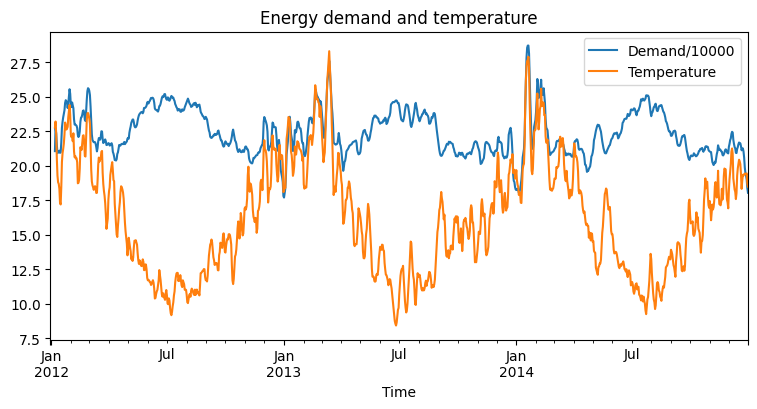

In [74]:
# Distribution of energy demand and temperature
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
(data['Demand'].rolling(window=7, closed='left').mean()/ 10000).plot(label='Demand/10000', ax=ax)
data['Temperature'].rolling(window=7, closed='left').mean().plot(label='Temperature', ax=ax)
ax.set_title('Energy demand and temperature')
ax.legend();

## Create and train forecaster

A forecasting model is created to predict the energy demand using the past 7 values (last week) and the temperature as an exogenous variable.

In [75]:
# Create a recursive multi-step forecaster (ForecasterAutoreg)
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = HistGradientBoostingRegressor(random_state=123),
                 lags      = 7
             )

forecaster.fit(
    y    = data['Demand'],
    exog = data['Temperature']
)

## Training matrices 

In [76]:
# Training matrices used by the forecaster to fit the internal regressor
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(
                        y    = data['Demand'],
                        exog = data['Temperature']
                    )
display(X_train.head(3))
display(y_train.head(3))

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,Temperature
Time,,,,,,,,
2012-01-07,205338.714620,211066.426550,213792.376946,258955.329422,275490.988882,227778.257304,82531.745918,24.098958
2012-01-08,200693.270298,205338.714620,211066.426550,213792.376946,258955.329422,275490.988882,227778.257304,20.223958
2012-01-09,200061.614738,200693.270298,205338.714620,211066.426550,213792.376946,258955.329422,275490.988882,19.161458


Time
2012-01-07    200693.270298
2012-01-08    200061.614738
2012-01-09    216201.836844
Freq: D, Name: y, dtype: float64

## Shap Values

### Shap explainer

The python implementation of [SHAP](https://shap.readthedocs.io/en/latest/index.html) is built along the explainers. These explainers are appropriate only for certain types or classes of algorithms. For example, the TreeExplainer is used for tree-based models.

In [77]:
# Create SHAP explainer
# ==============================================================================
explainer = shap.TreeExplainer(forecaster.regressor)
shap_values = explainer.shap_values(X_train)

### SHAP Summary Plot

The SHAP summary plot typically displays the feature importance or contribution of each feature to the model's output across multiple data points. It shows how much each feature contributes to pushing the model's prediction away from a base value (often the model's average prediction). By examining a SHAP summary plot, one can gain insights into which features have the most significant impact on predictions, whether they positively or negatively influence the outcome, and how different feature values contribute to specific predictions.

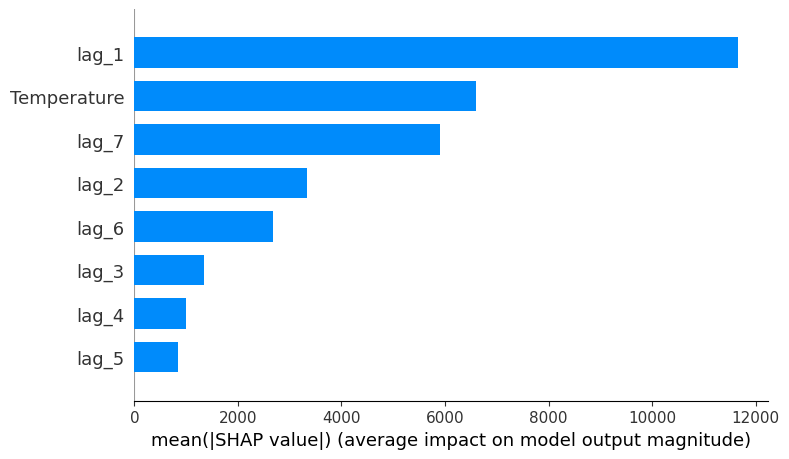

In [78]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

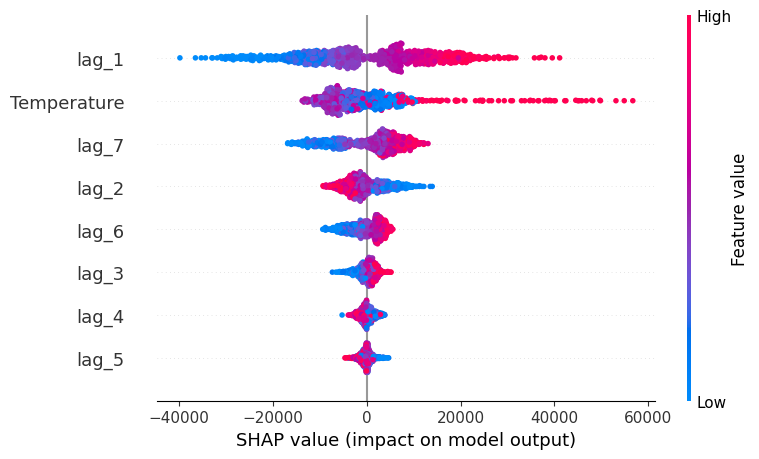

In [79]:
shap.summary_plot(shap_values, X_train)

### Explain individual predictions

A `shap.force_plot` is a specific type of visualization that provides an interactive and detailed view of how individual features contribute to a particular prediction made by a machine learning model. It's a local interpretation tool that helps understand why a model made a specific prediction for a given instance.

**Visualize a single prediction**

In [80]:
# Force plot for the first observation
# ==============================================================================
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

**Visualize many predictions**

In [81]:
# Force plot for the first 200 observations in the training set
# ==============================================================================
shap.force_plot(explainer.expected_value, shap_values[:200,:], X_train.iloc[:200,:])

### SHAP Dependence Plots

SHAP dependence plots are visualizations used to understand the relationship between a feature and the model output by displaying how the value of a single feature affects predictions made by the model while considering interactions with other features. These plots are particularly useful for examining how a certain feature impacts the model's predictions across its range of values while considering interactions with other variables. 

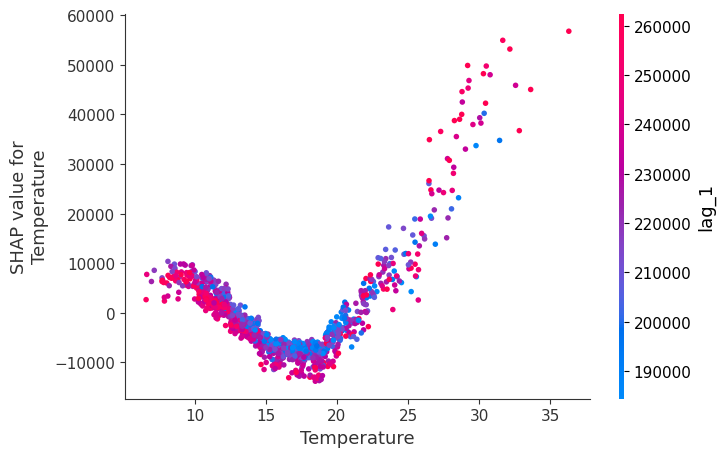

In [82]:
# Dependence plot for Temperature
# ==============================================================================
shap.dependence_plot("Temperature", shap_values, X_train)

## Scikit-learn partial dependence plots

Partial dependence plots (PDPs) are a useful tool for understanding the relationship between a feature and the target outcome in a machine learning model. In scikit-learn, you can create partial dependence plots using the `plot_partial_dependence` function. This function visualizes the effect of one or two features on the predicted outcome, while marginalizing the effect of all other features.

The resulting plots show how changes in the selected feature(s) affect the predicted outcome while holding other features constant on average. Remember that these plots should be interpreted in the context of your model and data. They provide insight into the relationship between specific features and the model's predictions.

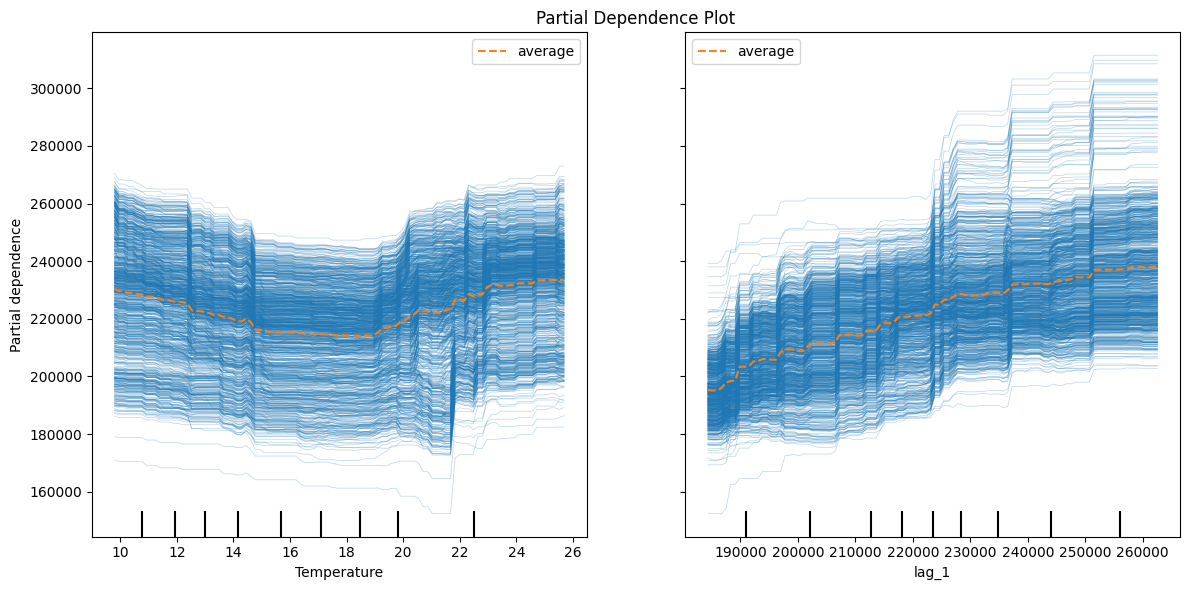

In [93]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Decision Tree")
pd.plots = PartialDependenceDisplay.from_estimator(
    estimator=forecaster.regressor,
    X=X_train,
    features=["Temperature", "lag_1"],
    kind='both',
    ax=ax,
)
ax.set_title("Partial Dependence Plot")
fig.tight_layout();